In [5]:
import numpy as np
import scipy as sp
from scipy import interpolate
import cv2 as cv
import matplotlib.pyplot as plt

# Part A: Factored Sampling
Code for factored sampling

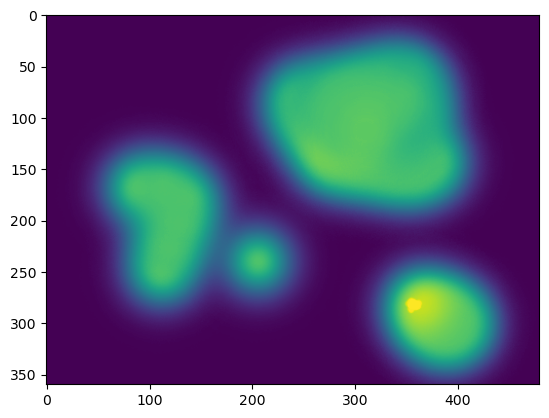

In [6]:
img = cv.imread('data/abstract.png')
measurementsComprehensive = img[:,:,2]
plt.imshow(measurementsComprehensive)
plt.show()

In [7]:
imgHeight, imgWidth, colors = img.shape
numParticles = 150;
# Initialize which samples from "last time" to propagate: all of
# them!:
samples_to_propagate = range(0, numParticles)
numDims_w = 2

Iteration  0 :


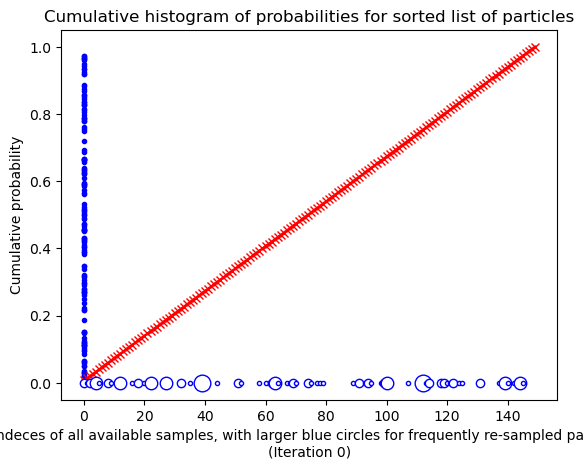

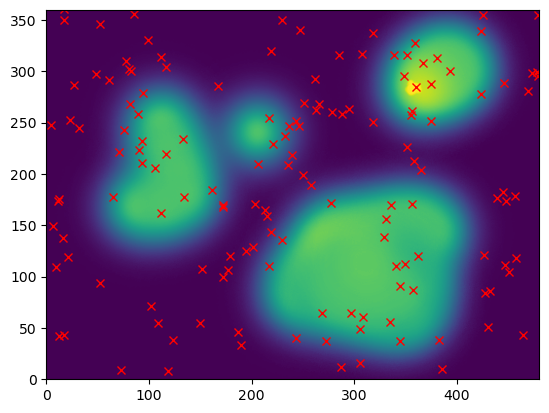

C:\Users\dudu2\AppData\Local\Temp\ipykernel_32900\2874483777.py:91: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interpolation_func = sp.interpolate.interp2d(np.arange(0, imgWidth),
C:\Users\dudu2\AppData\Local\Temp\ipykernel_32900\2874483777.py:94: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisp

Iteration  1 :


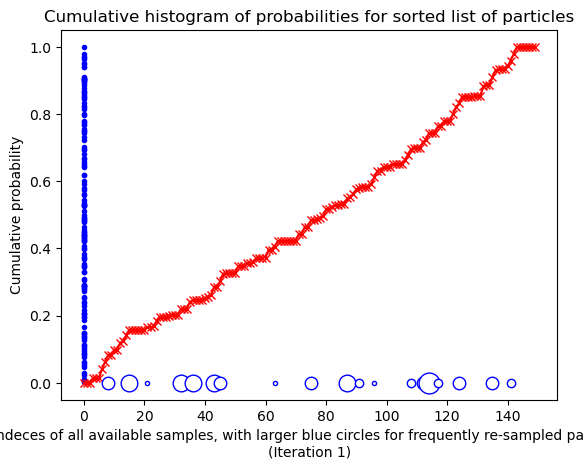

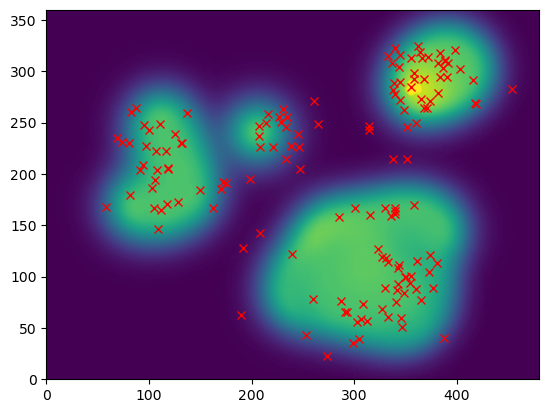

Iteration  2 :


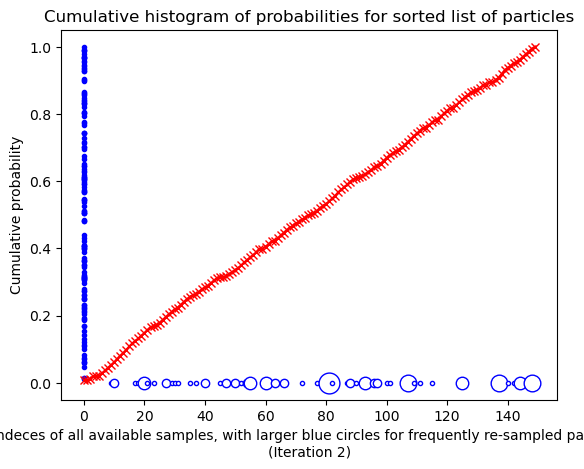

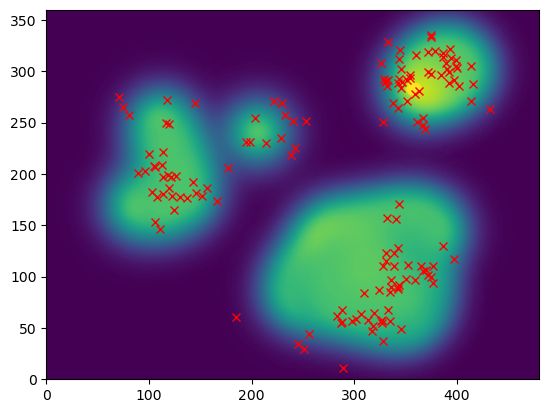

Iteration  3 :


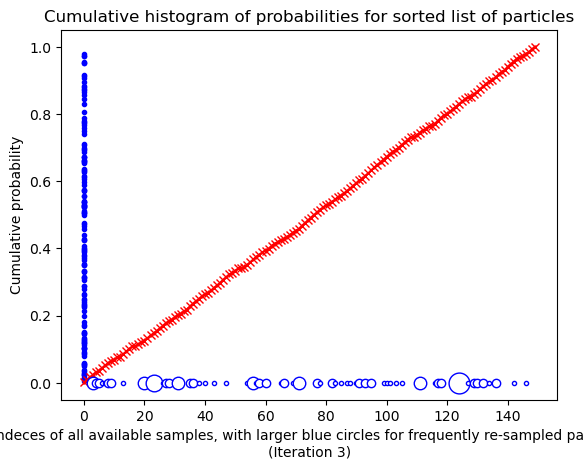

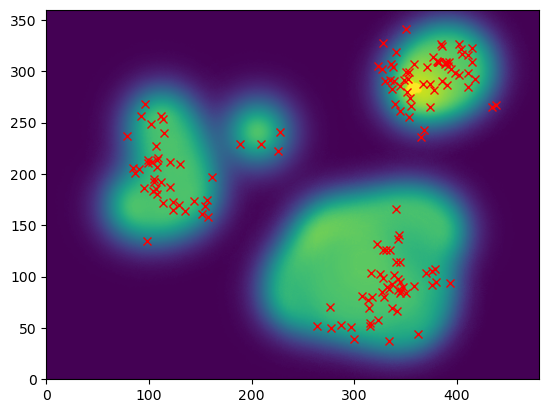

Iteration  4 :


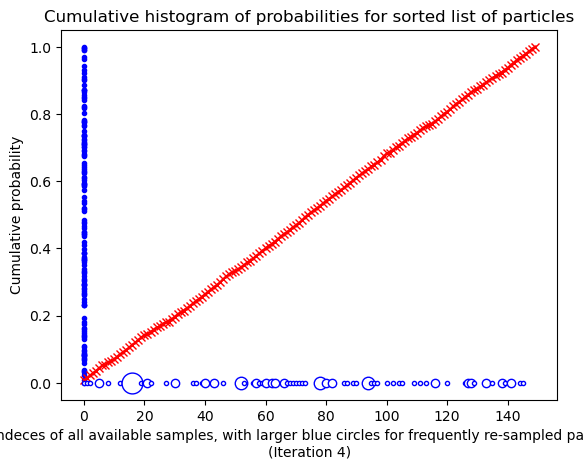

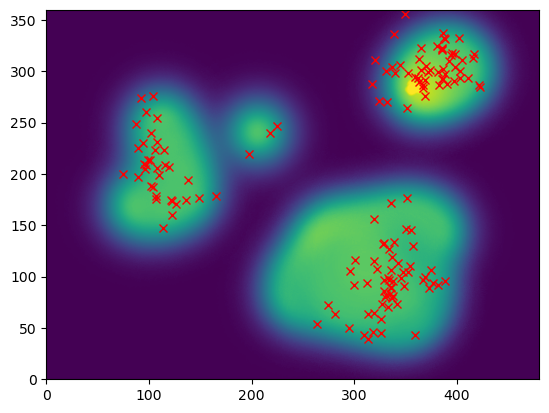

Iteration  5 :


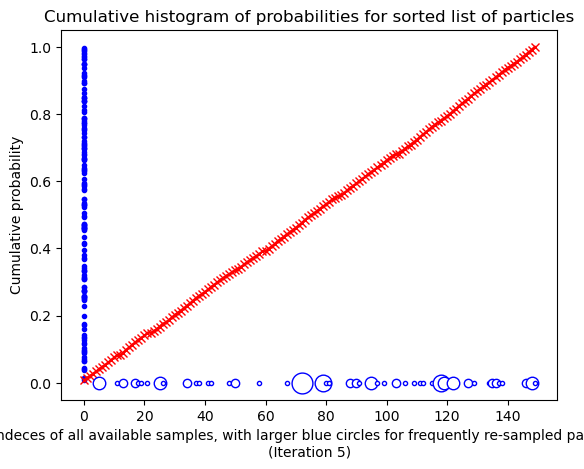

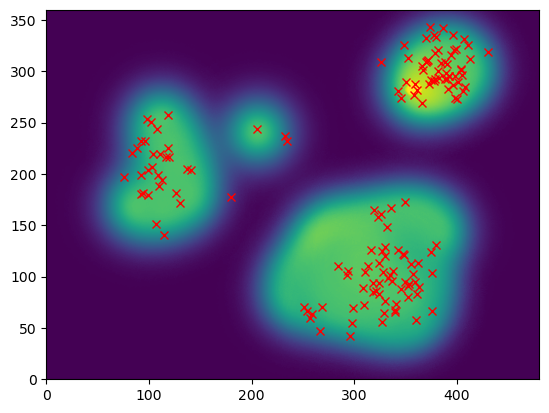

Iteration  6 :


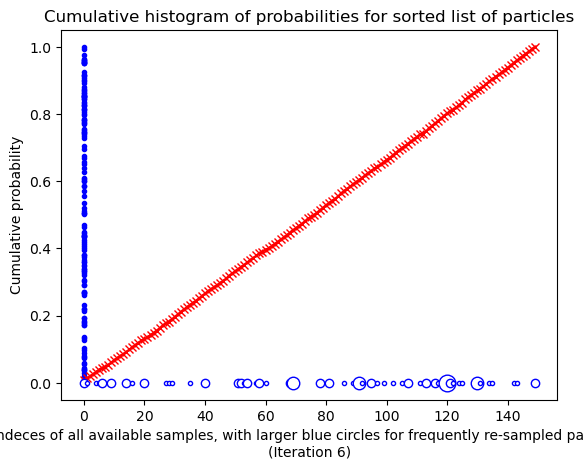

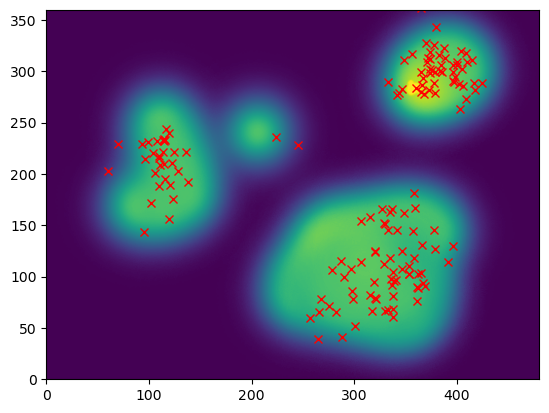

Iteration  7 :


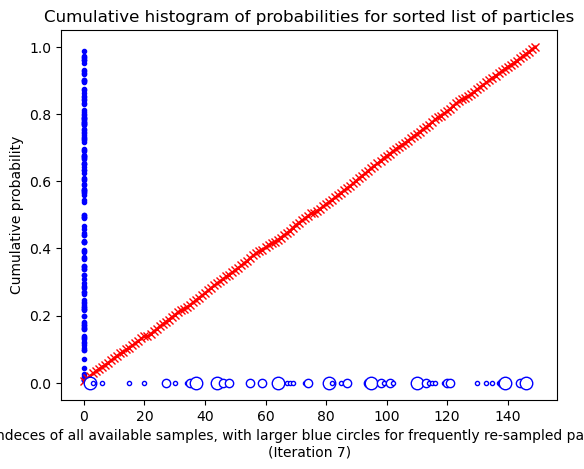

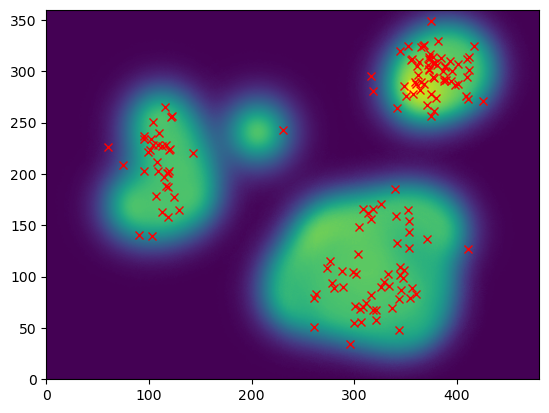

Iteration  8 :


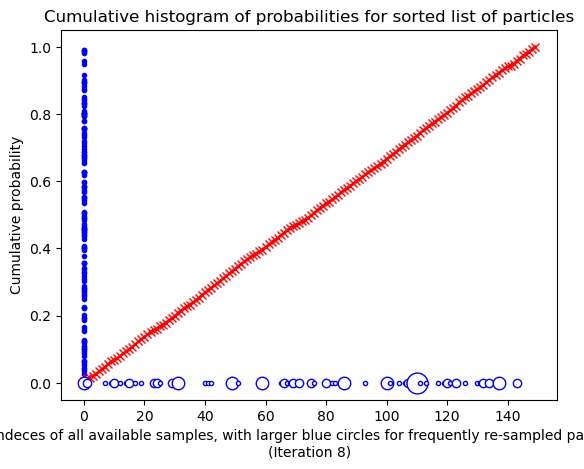

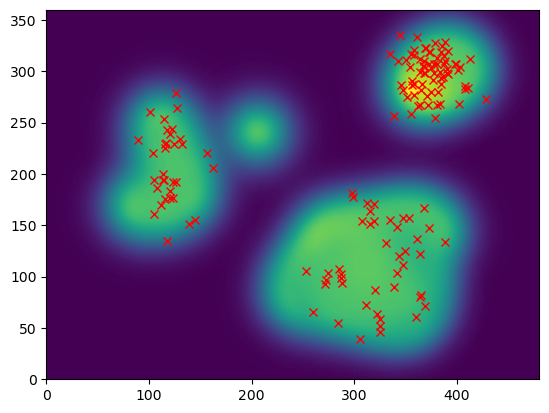

Iteration  9 :


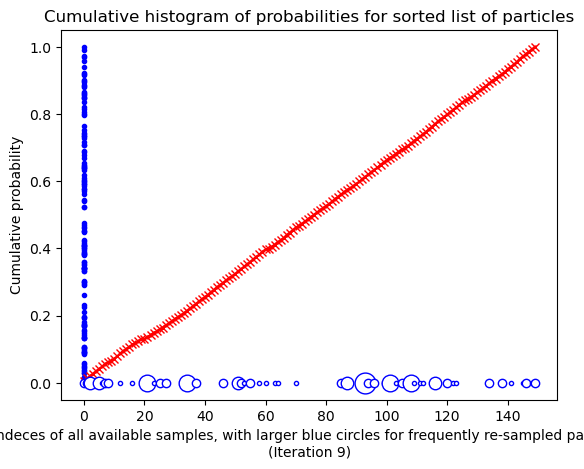

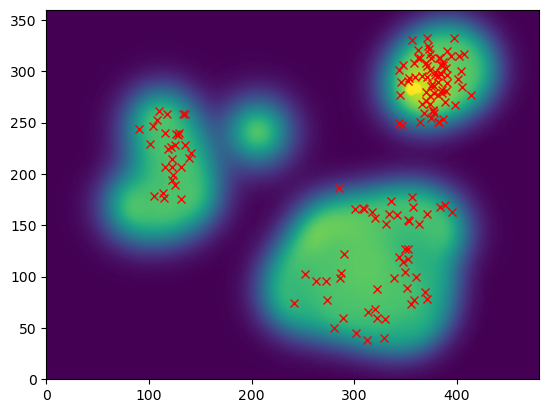

In [8]:
# Here randomly initialize some particles throughout the space of w.
# The positions of such particles are quite close to the known initial position:
particles_old = np.random.rand(numParticles, numDims_w)

# clipping here is just done to simplify plotting - we want everything to 'fit'
particles_old[:,0] = particles_old[:,0] * imgHeight
particles_old[:,1] = particles_old[:,1] * imgWidth

weight_of_samples = np.ones((numParticles,1))
# Normalize the weights
weight_of_samples = weight_of_samples/weight_of_samples.sum()

# Loop here to see what factored resampling would look like.
for iTime in range(10):
    print('Iteration ', iTime, ':')
    # Compute the cumulative sum of the weights
    cum_hist_of_weights = np.cumsum(weight_of_samples, axis=0)

    # Resample the old distribution (at time t-1), favoring samples that had
    # a higher posterior probability
    samples_to_propagate = np.zeros((numParticles,1), dtype=np.int32)
    
    # Pick random thresholds in the cumulative probability's range [0,1]: 
    some_threshes = np.random.rand(numParticles,1)

    # For each random threshold, find which sample in the ordered set is the
    # first one to push the cumulative probability above that threshold. 
    # E.g. if the cumulative histogram goes from 0.23 to 0.26 between the 17th
    # and 18th samples in the old distribution, and the threshold is 0.234,
    # then we'll want to propagate the 18th sample's w (i.e. particle #18).
    for sampNum in range(numParticles): 
        thresh = some_threshes[sampNum]
        for index in range(numParticles):
            if cum_hist_of_weights[index] > thresh:
                break
        samples_to_propagate[sampNum] = index
    
    # Note: it's ok if some of the old particles get picked repeatedly, while
    # others don't get picked at all.

    # =================================================
    # Visualize
    # =================================================
    plt.title('Cumulative histogram of probabilities for sorted list of particles')
    plt.plot(np.zeros(numParticles), some_threshes,'b.')
    plt.plot(range(0, numParticles), cum_hist_of_weights, 'rx-')
    which_sample_ids = np.unique(samples_to_propagate)
    how_many_of_each = np.bincount(np.ravel(samples_to_propagate))
    for k in range(len(which_sample_ids)):
        plt.plot(which_sample_ids[k], 0, 'bo-', markersize = 3 * how_many_of_each[k], markerfacecolor='white')
    plt.xlabel('Indeces of all available samples, with larger blue circles for frequently re-sampled particles\n(Iteration %01d)' % iTime)
    plt.ylabel('Cumulative probability');
    plt.show()
    # =================================================
    # =================================================

    # Predict where the particles we sampled from the old distribution of 
    # state-space will go in the next time-step. This means applying 
    # the motion model to each old sample.
    particles_new = np.zeros_like(particles_old)
    for particleNum in range(numParticles):
        # Incorporate some noise, e.g. Gaussian noise with std 10,
        # into the current location (particles_old), to give a Brownian
        # motion model.
        particles_new[particleNum, :] = particles_old[samples_to_propagate[particleNum], :] + np.random.normal(0,10,(particles_old[samples_to_propagate[particleNum],:]).shape)
    
    measurementsComprehensive = img[:,:,2]
    plt.imshow(measurementsComprehensive)
    axes = plt.gca()
    axes.set_xlim([0, imgWidth])
    axes.set_ylim([0, imgHeight])
    # now draw the particles onto the image
    plt.plot(particles_new[:,1], particles_new[:,0], 'rx')
    plt.show()

    # Incorporate the sensor measurement for the new state (time t):
    # The new particles, accompanied with predicted locations in world state-space
    # for time t, are missing their weights: how well does each particle
    # explain the observation x_t
    for particleNum in range(numParticles):
        # Convert the particle from state-space w to measurement-space x:
        # Note: It is trivial in this case because both are in 2D space of image
        # coordinates

        # Within the loop, evaluate the likelihood of each particle:
        particle = particles_new[particleNum, :]
        # Check that the predicted location is a place that
        # the likelihood can be really evaluate
        inFrame = particle[0] >= 1.0 and  particle[0] <= imgHeight and particle[1] >= 1.0 and particle[1] <= imgWidth
        if inFrame:
            interpolation_func = sp.interpolate.interp2d(np.arange(0, imgWidth),
                                                         np.arange(0, imgHeight),
                                                         measurementsComprehensive)
            weight_of_samples[particleNum] = interpolation_func(particles_new[particleNum, 1], particles_new[particleNum, 0])
        else:
            weight_of_samples[particleNum] = 0.0

    # Normalize the weights 
    weight_of_samples = weight_of_samples/weight_of_samples.sum()
    particles_old = particles_new;


In iteration 0, the weights are initialized equally, leading to roughly equally-sized blue circles in the "Cumulative histogram of probabilities for sorted list of particles" diagram, indicating few resampling. 

Along with the iteration, the weights of the points with unevaluable likelihood (outside the bright area) are set to zero as the sensor measurements are incorporated, bigger circles occur on the horizontal axis, meaning reampling happens more often as more information from the last iteration is considered, and the red crosses are more and more concentrated on the bright areas. Besides, a small number of red crosses are located outside of the glowing area near the border, this could be because of the noises added to the motion model. 